In [25]:
#HARMFUL BRAIN ACTIVITY CLASSIFICATION PROJECT 
''' Sponsor : Ali Ibrahim 

    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names

'''

' Sponsor : Ali Ibrahim \n\n    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names\n\n'

In [ ]:
#Pre-processing of Data :  Estuardo & Manny 

# Import necessary libraries for data handling, signal processing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
from mne.preprocessing import ICA

#
## IF LIBRARIES ARE THROWING AN ERROR: 
## Open terminal and run: pip install 'name_of_library', e.g., pip install pandas 

# ATTENTION!!!!!! : Change the directory path to your dataset
#Manny C:/Users/Master/Documents/Project Data/hms-harmful-brain-activity-classification/train_eegs
#Estuardo /Users/estuardomelendez/Downloads/hms-harmful-brain-activity-classification/train_eegs
#Kevin "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"

# Directory containing the training EEG files (raw data)
train_eegs_dir = "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"


'''
hms-harmful-brain-activity-classification---- Data composition: 


train_eegs = Contains time-domain data
train_spectogram = Contains frequency-domain data
'''

# List all .parquet files in the specified directory
all_files = [os.path.join(train_eegs_dir, f) for f in os.listdir(train_eegs_dir) if f.endswith(".parquet")]

'''
## files_to_process can be changed to any integer between 1-100 for demo purposes or "ALL" for all files to be processed
   (processing all parquet files can take a long time)
'''
# Allows processing of either a subset of files ex (1-100) or all files in the directory
files_to_process = "ALL" # Change to "ALL" for processing all files

# which files to be processed 
if isinstance(files_to_process, int) and 1 <= files_to_process <= 100:
    files_to_process_list = all_files[:files_to_process]
elif files_to_process == "ALL":
    files_to_process_list = all_files
else:
    raise ValueError("files_to_process must be an integer between 1 and 100 or 'ALL'.")

# EEG Channel-to-Description Mapping: Maps channel names to their corresponding brain regions
channel_mapping = {
    "Fp1": "Frontal pole on the left hemisphere",
    "Fp2": "Frontal pole on the right hemisphere",
    "F3": "Frontal lobe on the left hemisphere",
    "F4": "Frontal lobe on the right hemisphere",
    "C3": "Central area on the left hemisphere",
    "C4": "Central area on the right hemisphere",
    "P3": "Parietal lobe on the left hemisphere",
    "P4": "Parietal lobe on the right hemisphere",
    "O1": "Occipital lobe on the left hemisphere",
    "O2": "Occipital lobe on the right hemisphere",
    "F7": "Anterior temporal lobe on the left hemisphere",
    "F8": "Anterior temporal lobe on the right hemisphere",
    "T3": "Mid-temporal lobe on the left hemisphere",
    "T4": "Mid-temporal lobe on the right hemisphere",
    "T5": "Posterior temporal lobe on the left hemisphere",
    "T6": "Posterior temporal lobe on the right hemisphere",
    "Fz": "Frontal midline",
    "Cz": "Central midline",
    "Pz": "Parietal midline"
}

# STEP 1: Notch filter function
def apply_notch_filter(signal, fs, freq=60.0, quality_factor=2.0):
    
    """
    Removes powerline noise at a specific frequency (default 60 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        freq: Frequency to remove (Hz, default = 60).
        quality_factor: Quality factor of the notch filter (default = 2.0).
    Returns:
        Filtered signal with the specified frequency removed.
    """

    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return filtfilt(b, a, signal)

# STEP 2: Bandpass Filter function
def apply_bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=5):
    
    """
    Retains signal components within a specific frequency range (default: 0.5–40 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        lowcut: Lower frequency bound (Hz, default = 0.5).
        highcut: Upper frequency bound (Hz, default = 40).
        order: Filter order (default = 5).
    Returns:
        Bandpass-filtered signal.
    """

    nyquist = 0.5 * fs # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# STEP 3: Artifact Removal with ICA (Optional)
def apply_ica(signal, fs, n_components=10):
    
    ica = ICA(n_components=n_components, random_state=42, max_iter='auto')
    signal_df = pd.DataFrame(signal)  # Convert signal to DataFrame for ICA compatibility
    ica.fit(signal_df)
    cleaned_signal = ica.apply(signal_df)
    return cleaned_signal.values  # Return cleaned signal as numpy array

# STEP 4: Normalize Signal
def normalize_signal(signal):
   
     return (signal - np.mean(signal)) / np.std(signal)

# STEP 5: Spectrogram Plot with Descriptions
def plot_spectrogram_with_description(signal, fs, channel_name, title_prefix="Spectrogram"):
    
    #Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    #Generate the spectrogram
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=128)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    
    #Add a descriptive title
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, 100)  # Limit to 100 Hz for EEG signals
    plt.show()

# function for Time-domain Plot
def plot_time_domain(signal, fs, channel_name, title_prefix="Signal in Time Domain"):
    
    # Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Preprocess and visualize a single File:
def process_single_file(file_path, fs=200):
    
    # Load data
    data = pd.read_parquet(file_path)
    print(f"Processing file: {file_path}")
    print(data.head())

    processed_data = {}
    for column in data.columns:
        raw_signal = data[column].values
        
        #Plot raw signal spectrogram
        plot_spectrogram_with_description(raw_signal, fs, channel_name=column, title_prefix="Raw Spectrogram")
        plot_time_domain(raw_signal, fs, channel_name=column, title_prefix="Raw Signal")
        
        #Apply notch filter and bandpass filter
        notch_filtered_signal = apply_notch_filter(raw_signal, fs, freq=60.0)
        bandpass_filtered_signal = apply_bandpass_filter(notch_filtered_signal, fs, lowcut=0.5, highcut=40.0)
        
        # Normalize the signal
        normalized_signal = normalize_signal(bandpass_filtered_signal)
        
        # (Optional) Apply ICA for artifact removal
        # cleaned_signal = apply_ica(normalized_signal, fs)  # Uncomment if ICA is needed
        
        #Plot processed signal spectrogram and time-domain signal
        plot_spectrogram_with_description(normalized_signal, fs, channel_name=column, title_prefix="Processed Spectrogram")
        plot_time_domain(normalized_signal, fs, channel_name=column, title_prefix="Processed Signal")
        
        # Store processed data
        processed_data[column] = normalized_signal

    # Convert processed data back to DataFrame
    processed_df = pd.DataFrame(processed_data)
    return processed_df

#Batch Process Files
def batch_process_files(file_list, output_dir=None, fs=200):
    
    for file_path in file_list:
        processed_df = process_single_file(file_path, fs=fs)
        
        # Optionally save the processed data
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, os.path.basename(file_path))
            processed_df.to_parquet(output_file)
            print(f"Saved processed file to: {output_file}")

''' 
ATTENTION: CHANGE OUTPUT DIRECTORY F  output_dir  TO THE FILEPATH OF THE FOLDER WHERE YOU WANT TO SAVE THE PRE-PROCESSED EEGS!!!
'''
# Output Directory for Processed Files
#estuardo /Users/estuardomelendez/Desktop/processed_eegs
#manny /Users/Master/Documents/Project Data/processed_eegs
output_dir = "C:/Users/Kevin Tran/Documents/Project Data/processed_eegs"  # CHANGE TO YOUR OWN DIRECTORY 

# Run Batch Processing with Sampling Frequency of 200 --- Can be changed according to professors instructions:

batch_process_files(files_to_process_list, output_dir=output_dir, fs=200)



In [ ]:
#Preprocessing Step with Parallel Processing: Kevin             Allows for quick execution of processing all 17300 files


import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt, iirnotch
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 📌 Define directories
raw_data_dir = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train_eegs"
processed_data_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"
os.makedirs(processed_data_dir, exist_ok=True)  # Ensure processed folder exists

# 📌 Verify if the EEG folder exists
if not os.path.exists(raw_data_dir):
    raise FileNotFoundError(f"🚨 ERROR: The directory {raw_data_dir} does not exist. Please check the path.")

# 📌 List all files to process
all_files = [os.path.join(raw_data_dir, f) for f in os.listdir(raw_data_dir) if f.endswith(".parquet")]

# 📌 Check if there are files to process
if len(all_files) == 0:
    raise FileNotFoundError(f"🚨 ERROR: No .parquet files found in {raw_data_dir}. Please check the folder contents.")

print(f"✅ Found {len(all_files)} .parquet files in {raw_data_dir}. Ready to process.\n")

# 📌 Define EEG Preprocessing Functions
def apply_notch_filter(signal, fs=200, freq=60.0, quality_factor=30):
    """Apply a notch filter to remove 60Hz noise."""
    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return filtfilt(b, a, signal)

def apply_bandpass_filter(signal, fs=200, lowcut=0.5, highcut=40.0, order=5):
    """Apply a bandpass filter to keep frequencies between 0.5Hz and 40Hz."""
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    """Normalize EEG signal to have zero mean and unit variance."""
    return (signal - np.mean(signal)) / np.std(signal)

# 📌 Function to preprocess a single EEG file
def process_single_file(file_path):
    try:
        # Load EEG Data
        data = pd.read_parquet(file_path)

        # Preprocess each EEG channel
        processed_data = {}
        for channel in data.columns:
            signal = data[channel].values
            signal = apply_notch_filter(signal)  # Remove powerline noise
            signal = apply_bandpass_filter(signal)  # Keep only relevant frequencies
            signal = normalize_signal(signal)  # Normalize the signal
            processed_data[channel] = signal
        
        # Save the processed data
        processed_df = pd.DataFrame(processed_data)
        output_file = os.path.join(processed_data_dir, os.path.basename(file_path))
        processed_df.to_parquet(output_file)
        return f"✅ Success: {os.path.basename(file_path)}"
    
    except Exception as e:
        return f"❌ Failed: {os.path.basename(file_path)} | Error: {e}"

# 📌 Threaded Batch Processing
def batch_process_files_threading(file_list, num_workers=os.cpu_count()//4):
    batch_size = 100  # Process files in batches of 100
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i + batch_size]
        print(f"🚀 Processing Batch {i//batch_size+1}/{len(file_list)//batch_size+1} ({len(batch)} files)...")
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(executor.map(process_single_file, batch), total=len(batch), desc=f"Batch {i//batch_size+1}"))

        # Summary of results for the current batch
        success = [res for res in results if res.startswith("✅")]
        failed = [res for res in results if res.startswith("❌")]
        print(f"✔️ Batch Summary: {len(success)} Success, {len(failed)} Failed\n")
        if failed:
            print(f"❌ Failed Files: {'; '.join(failed)}\n")

# 📌 Run Preprocessing
if __name__ == "__main__":
    print(f"Starting threaded processing for {len(all_files)} files...\n")
    batch_process_files_threading(all_files)
    print("✅ All EEG files have been processed and saved.\n")


In [5]:
#FEATURE EXTRACTION: Estuardo & Manny 
'''
Preliminary implementation for feature extraction, We divided the parquet eeg file into 2 second intervals
and extracted time domain features such as :[mean, variance, skewness, kurtosis, rms, delta power, theta power ,alpha power, beta power & gamma]

Me & Manny are still waiting on our Sposors feedback, you will find a eeg_features file which I recommend you open with the RAINBOW CSV extension
for visual studio.

#Remember to change file paths to your own dataset directory and comment out the previos one

'''

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os

# CHANGE DIRECTORY TO YOU PROCESSED EEGS!!!!!
#Estuardo "/Users/estuardomelendez/Desktop/processed_eegs"
#Manny "C:/Users/Master/Documents/GitHub/ED1-PROJECT2024/processed_eegs" 
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]


# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples

#Function to split data into windows
def split_into_windows(signal, window_size):
    
    num_windows = len(signal) // window_size # Calculate number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]
    return windows

#Function to extract time-domain features
def extract_time_features(signal):
    
    features = {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)
    }
    return features

#function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    
    freqs, psd = welch(signal, fs=fs, nperseg=256) #Compute PSD using Welch's method
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10)) ## Avoid log(0) with small offset
    }
    return band_powers

#function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
   
    # Load processed EEG data
    data = pd.read_parquet(file_path)
    
    # Extract features for each channel
    all_features = []
    for channel in data.columns:
        signal = data[channel].values
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            time_features = extract_time_features(window)
            frequency_features = extract_frequency_features(window, fs)
            combined_features = {
                "file": os.path.basename(file_path),
                "channel": channel,
                "window": i,
                **time_features,
                **frequency_features
            }
            all_features.append(combined_features)
    
    # Return DataFrame with properly named columns
    return pd.DataFrame(all_features)

# Process all files and combine features by extracting features from all files in the directory
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine features from all files into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
#Estuardo "/Users/estuardomelendez/Desktop/eeg_features.csv"
#Manny /Users/Master/Documents/GitHub/ED1-PROJECT2024/eeg_features.csv
output_feature_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print(f"Features saved to: {output_feature_file}")
print("\nPreview of Extracted Features:")
print(all_features_df.head())





Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1000913311.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001369401.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001487592.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001717358.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002136740.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002142157.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002197945.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002379034.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002576868.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\proc

KeyboardInterrupt: 

In [9]:
#UPDATED Feature EXTRACTION

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os

# CHANGE DIRECTORY TO YOUR PROCESSED EEGS!!!!!
processed_eegs_dir = "C:/Users/Kevin Tran/Documents/Project Data/processed_eegs"
processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 400  # Updated sampling frequency to match professor's files
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds

# Define EEG frequency bands
bands = {
    "delta": (1, 3),
    "theta": (4, 7),
    "alpha1": (8, 9),
    "alpha2": (10, 12),
    "beta1": (13, 17),
    "beta2": (18, 30),
    "gamma1": (31, 40),
    "gamma2": (41, 50),
    "higher": (51, 250)
}

# List of 19 standard EEG channels
expected_channels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

# Function to split data into windows
def split_into_windows(signal, window_size):
    num_windows = len(signal) // window_size
    return [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]

# Function to extract time-domain features
def extract_time_features(signal):
    return {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal),
        "mean_abs": np.mean(np.abs(signal)),
        "diff_rms1": np.sqrt(np.mean(np.diff(signal) ** 2)),
        "diff_rms2": np.sqrt(np.mean(np.diff(signal, n=2) ** 2))
    }

# Function to extract frequency-domain features using FFT
def extract_frequency_features(signal, fs):
    L = len(signal)
    Y = np.fft.fft(signal)
    P2 = np.abs(Y / L)
    P1 = P2[:L // 2 + 1]
    P1[1:-1] *= 2
    freqs = fs * np.arange(L // 2 + 1) / L
    
    band_powers = {name: np.sum(P1[(freqs >= low) & (freqs <= high)]) for name, (low, high) in bands.items()}
    band_powers["spectral_entropy"] = -np.sum(P1 * np.log(P1 + 1e-10))
    return band_powers

# Function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
    data = pd.read_parquet(file_path)
    available_channels = [ch for ch in expected_channels if ch in data.columns]
    
    if len(available_channels) < len(expected_channels):
        print(f"Warning: Some expected EEG channels are missing in {file_path}")
    
    all_features = []
    
    for channel in available_channels:
        signal = data[channel].values
        windows = split_into_windows(signal, window_size_samples)
        
        for i, window in enumerate(windows):
            time_features = extract_time_features(window)
            frequency_features = extract_frequency_features(window, fs)
            
            combined_features = {
                "file": os.path.basename(file_path),
                "channel": channel,
                "window": i,
                **time_features,
                **frequency_features
            }
            all_features.append(combined_features)
    
    return pd.DataFrame(all_features)

# Process all files
combined_features = []
for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine features from all files into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file
output_feature_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview extracted features
print(f"Features saved to: {output_feature_file}")
print("\nPreview of Extracted Features:")
print(all_features_df.head())


Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1374471186.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1374547818.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1375074349.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1375604981.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1375905869.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1376244688.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1376294683.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1376378385.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/processed_eegs\1376681989.parquet
Extracting features from: C:/Users/Kevin Tran/Documents/Project Data/proc

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os
import matplotlib.pyplot as plt

# CHANGE DIRECTORY TO YOUR PROCESSED EEGS!!!
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

# List all .parquet files in the specified directory
processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples


# Function to split data into fixed-size windows
def split_into_windows(signal, window_size):
    """
    Splits the input signal into fixed-size windows.
    Args:
        signal: The input EEG signal (1D array).
        window_size: Number of samples per window.
    Returns:
        A list of equally-sized signal windows.
    """
    num_windows = len(signal) // window_size  # Calculate the number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]  # Slice the signal
    return windows


# Function to extract time-domain features
def extract_time_features(signal):
    """
    Extracts statistical features from the signal in the time domain.
    Args:
        signal: The input EEG signal (1D array).
    Returns:
        A dictionary containing the computed features.
    """
    features = {
        "mean": np.mean(signal),  # Average value of the signal
        "variance": np.var(signal),  # Variability in the signal
        "skewness": skew(signal),  # Asymmetry of the signal
        "kurtosis": kurtosis(signal),  # "Peakedness" of the signal
        "rms": np.sqrt(np.mean(signal**2)),  # Root Mean Square of the signal
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)  # Rate of zero crossings
    }
    return features


# Function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    """
    Extracts frequency domain features from the signal using Welch's method.
    Args:
        signal: The input EEG signal (1D array).
        fs: Sampling frequency of the signal.
    Returns:
        A dictionary containing the computed frequency-domain features.
    """
    # Compute Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    
    # Calculate band powers and spectral entropy
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),  # Power in delta band (0.5–4 Hz)
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),  # Power in theta band (4–8 Hz)
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),  # Power in alpha band (8–13 Hz)
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),  # Power in beta band (13–30 Hz)
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),  # Power in gamma band (30–50 Hz)
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10))  # Avoid log(0) with small offset
    }
    return band_powers


# Function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
    """
    Processes an EEG file to extract both time-domain and frequency-domain features.
    Args:
        file_path: Path to the EEG file.
        fs: Sampling frequency of the signal.
        window_size_samples: Number of samples in each window.
    Returns:
        A DataFrame containing features for all channels and windows.
    """
    data = pd.read_parquet(file_path)  # Load EEG data
    print(f"Processing file: {file_path}")

    all_features = []  # List to store features for all windows and channels
    
    # Process each channel in the EEG data
    for channel in data.columns:
        signal = data[channel].values  # Get the signal for the current channel
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            # Extract time-domain features
            time_features = extract_time_features(window)
            
            # Extract frequency-domain features
            frequency_features = extract_frequency_features(window, fs)
            
            # Combine features and add metadata
            combined_features = {
                "file": os.path.basename(file_path),  # File name
                "channel": channel,  # Channel name
                "window": i,  # Window index
                **time_features,  # Add time-domain features
                **frequency_features  # Add frequency-domain features
            }
            
            # Append to the list of all features
            all_features.append(combined_features)

    # Return the features as a DataFrame
    return pd.DataFrame(all_features)


# Process the first file to retrieve channel names
first_file_path = processed_files[0]
data = pd.read_parquet(first_file_path)
channels = data.columns.tolist()  # Get the list of channel names

# Process all files and combine features
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine all features into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
output_feature_file = r"C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print("\nExtracted Features:")
print(all_features_df.head())
print(f"Features saved to: {output_feature_file}")

# Visualize features for the first channel
first_channel_name = channels[0]  # Select the first channel
first_channel_features = all_features_df[all_features_df['channel'] == first_channel_name]

plt.plot(first_channel_features['window'], first_channel_features['delta_power'], label='Delta Power')
plt.title(f'Delta Power Across Windows - {first_channel_name}')
plt.xlabel('Window Index')
plt.ylabel('Delta Power')
plt.legend()
plt.show()


✅ Detailed anomalies saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv
✅ EEG ID classifications saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv


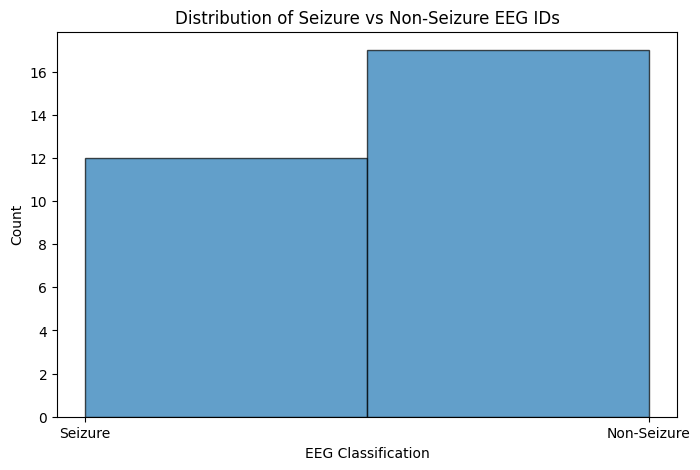

In [10]:
#Machine draft

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 📌 Load the extracted EEG feature dataset
features_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
df_features = pd.read_csv(features_file)

# 📌 Extract EEG ID from the filename
df_features["eeg_id"] = df_features["file"].str.extract(r'(\d+)')  # Extract numeric EEG ID

# 📌 Drop Non-Numeric Columns Before Handling NaNs
numeric_columns = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_columns] = df_features[numeric_columns].fillna(df_features[numeric_columns].mean())  # Fill NaNs

# 📌 Drop non-numeric columns for Isolation Forest
X = df_features[numeric_columns].copy()

# 📌 Train the Isolation Forest Model
iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_features["anomaly"] = iso_forest.fit_predict(X)  # -1 = Seizure-Like, 1 = Non-Seizure

# 📌 Save Detailed Anomalies for Each Channel
detailed_anomalies_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv"
df_features.to_csv(detailed_anomalies_file, index=False)
print(f"✅ Detailed anomalies saved to: {detailed_anomalies_file}")

# 📌 Aggregate Anomalies by EEG ID
# If any channel in an EEG ID is classified as an anomaly (-1), the entire EEG ID is classified as Seizure
eeg_classifications = df_features.groupby("eeg_id")["anomaly"].apply(lambda x: -1 if (x == -1).any() else 1).reset_index()
eeg_classifications["classification"] = eeg_classifications["anomaly"].map({-1: "Seizure", 1: "Non-Seizure"})

# 📌 Save Results with EEG IDs
eeg_classifications_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv"
eeg_classifications.to_csv(eeg_classifications_file, index=False)
print(f"✅ EEG ID classifications saved to: {eeg_classifications_file}")

# 📊 Plot Distribution of EEG IDs (Seizure vs Non-Seizure)
plt.figure(figsize=(8, 5))
plt.hist(eeg_classifications["classification"], bins=2, edgecolor="black", alpha=0.7)
plt.xlabel("EEG Classification")
plt.ylabel("Count")
plt.title("Distribution of Seizure vs Non-Seizure EEG IDs")
plt.show()


In [ ]:
#machine learning test 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib

# 📌 Define File Paths
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
processed_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features_processed.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"

# 📌 Load Train Labels (Seizure vs. Non-Seizure)
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})  # Keep EEG ID as string to save memory
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# 📌 Create a File to Store Processed Data (Instead of Keeping in RAM)
if os.path.exists(processed_output_path):
    os.remove(processed_output_path)  # Remove existing file to prevent duplicates

# 📌 Process EEG Features in Chunks & Write Directly to File
chunk_size = 50000  # Process 50,000 rows at a time
print("🚀 Processing EEG feature chunks...")

for i, chunk in enumerate(pd.read_csv(features_file_path, dtype={'file': 'str'}, chunksize=chunk_size)):
    chunk["file"] = chunk["file"].str.replace(".parquet", "", regex=False)  # Ensure filename consistency
    merged_chunk = chunk.merge(df_labels, on="file", how="inner")  # Merge with train.csv labels

    # Append to output CSV to avoid keeping everything in RAM
    merged_chunk.to_csv(processed_output_path, mode='a', index=False, header=(i == 0))  # Write header only once
    print(f"✅ Processed {len(merged_chunk)} rows. Total Chunks: {i+1}")

print(f"✅ All data successfully processed and saved to: {processed_output_path}")

# 📌 Load the Processed File (Much Smaller Than Before)
df = pd.read_csv(processed_output_path)

# 📌 Drop Unnecessary Columns
df.drop(columns=["file", "channel", "window"], inplace=True, errors="ignore")

# 📌 Define Features and Target Variable
X = df.drop(columns=["expert_consensus"])  # Features (EEG extracted values)
y = df["expert_consensus"].map({"seizure": 1, "non_seizure": 0})  # Convert labels to binary (1=Seizure, 0=Non-Seizure)

# 📌 Reduce Memory Usage by Converting to Float32
X = X.astype(np.float32)

# 📌 Train-Test Split (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Train a Machine Learning Model (Random Forest)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 📌 Predictions
y_pred = model.predict(X_test)

# 📌 Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Save Model
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")


✅ Processed 4396380 rows. Total Chunks: 34
✅ Processed 1212920 rows. Total Chunks: 35
✅ Processed 7854820 rows. Total Chunks: 36
✅ Processed 587480 rows. Total Chunks: 37
✅ Processed 515960 rows. Total Chunks: 38
✅ Processed 435260 rows. Total Chunks: 39
✅ Processed 568900 rows. Total Chunks: 40
✅ Processed 1004940 rows. Total Chunks: 41
✅ Processed 1033020 rows. Total Chunks: 42
✅ Processed 412020 rows. Total Chunks: 43
✅ Processed 498520 rows. Total Chunks: 44
✅ Processed 3413740 rows. Total Chunks: 45
✅ Processed 1244500 rows. Total Chunks: 46
✅ Processed 297520 rows. Total Chunks: 47
✅ Processed 9634280 rows. Total Chunks: 48
✅ Processed 6363100 rows. Total Chunks: 49
✅ Processed 532900 rows. Total Chunks: 50
✅ Processed 530520 rows. Total Chunks: 51
✅ Processed 369540 rows. Total Chunks: 52
✅ Processed 318280 rows. Total Chunks: 53
✅ Processed 5396140 rows. Total Chunks: 54
✅ Processed 388300 rows. Total Chunks: 55
✅ Processed 526440 rows. Total Chunks: 56
✅ Processed 356860 rows.

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [1]:
#Machine learning test 2


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib

# 📌 Define File Paths
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"
output_results_path = r"C:\Users\Kevin Tran\Documents\Project Data\test_results.csv"

# 🚀 **Step 1: Load EEG Feature Extraction Data**
print("🔄 Loading EEG Feature Extraction Data...")
chunk_size = 50000  # Load in chunks to save memory
chunks = []
for chunk in pd.read_csv(features_file_path, dtype={'file': 'str'}, chunksize=chunk_size, engine="python", on_bad_lines="skip"):
    chunks.append(chunk)
df_features = pd.concat(chunks, ignore_index=True)
del chunks  # Free up memory

# 📌 Drop Unnecessary Columns
df_features.drop(columns=["channel", "window"], inplace=True, errors="ignore")

# ✅ **Fix: Remove `.parquet` from EEG File Names**
df_features["file"] = df_features["file"].str.replace(".parquet", "", regex=False)

# 🔄 **Step 2: Aggregate Data by EEG ID**
print("🔄 Grouping EEG Data by ID...")
df_grouped = df_features.groupby("file", as_index=False).mean()

# 🚀 **Step 3: Load Train Labels (Seizure vs. Non-Seizure)**
print("🔄 Loading Train Labels from `train.csv`...")
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})  # Ensure EEG IDs are strings
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# ✅ **Fix: Ensure EEG IDs Are Strings Before Merging**
df_grouped["file"] = df_grouped["file"].astype(str)
df_labels["file"] = df_labels["file"].astype(str)

# 🔄 **Step 4: Merge EEG Features with Labels**
print("🔄 Merging EEG Features with Seizure Labels...")
df_merged = df_grouped.merge(df_labels, on="file", how="left")  # Left join to keep all EEGs

# ✅ **Fix: Convert Seizure Labels**
df_merged["expert_consensus"] = df_merged["expert_consensus"].fillna("non-seizure")  # Assume missing values are non-seizure

# 📌 **Convert to Binary Labels (1 = Seizure, 0 = Non-Seizure)**
df_merged["expert_consensus"] = df_merged["expert_consensus"].apply(lambda x: 1 if x == "seizure" else 0)

# ✅ **Fix: Remove Infinite & Extremely Large Values**
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
df_merged.dropna(inplace=True)  # Drop any rows with NaN values

# 📌 **Define Features & Target**
X = df_merged.drop(columns=["file", "expert_consensus"])
y = df_merged["expert_consensus"]

# ✅ **Ensure No Inf or Extremely Large Values**
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)  # Replace any remaining NaNs with 0

# 📌 **Reduce Memory Usage**
X = X.astype(np.float32)  # Use `float32` instead of `float16` for numerical stability

# 🚀 **Step 5: Train-Test Split (80% Train, 20% Test)**
print("🔄 Splitting Data into Training & Testing Sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ **Confirm Split**
print(f"✅ Total EEG Samples: {len(X)}")
print(f"📊 Training Samples: {len(X_train)} (80%)")
print(f"📊 Testing Samples: {len(X_test)} (20%)")

# ✅ **Notify When Test Data is Being Processed**
print(f"🔔 {len(X_test)} EEG IDs selected for testing... Model Training Begins! 🚀")

# 📌 **Step 6: Train Machine Learning Model (Random Forest)**
print("🚀 Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)  # Optimize memory usage
model.fit(X_train, y_train)

# 📌 **Step 7: Predictions**
y_pred = model.predict(X_test)

# 📌 **Step 8: Evaluate Model Performance**
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 **Step 9: Save Model**
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")

# 📌 **Step 10: Save Test Results to CSV**
test_results = pd.DataFrame({
    "file": X_test.index,  # Ensure `file` corresponds to EEG ID
    "predicted_label": ["Seizure" if pred == 1 else "Non-Seizure" for pred in y_pred],
    "actual_label": ["Seizure" if actual == 1 else "Non-Seizure" for actual in y_test]
})

# Map back to EEG IDs from the merged dataset
test_results["file"] = df_merged.loc[test_results["file"], "file"].values  # Map index to EEG IDs

# Save to CSV
test_results.to_csv(output_results_path, index=False)
print(f"✅ Test results saved to: {output_results_path}")


🔄 Loading EEG Feature Extraction Data...
🔄 Grouping EEG Data by ID...
🔄 Loading Train Labels from `train.csv`...
🔄 Merging EEG Features with Seizure Labels...
🔄 Splitting Data into Training & Testing Sets...
✅ Total EEG Samples: 95948
📊 Training Samples: 76758 (80%)
📊 Testing Samples: 19190 (20%)
🔔 19190 EEG IDs selected for testing... Model Training Begins! 🚀
🚀 Training Random Forest Classifier...
✅ Model Accuracy: 1.0000

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19190

    accuracy                           1.00     19190
   macro avg       1.00      1.00      1.00     19190
weighted avg       1.00      1.00      1.00     19190

✅ Model saved at: C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl
✅ Test results saved to: C:\Users\Kevin Tran\Documents\Project Data\test_results.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 📌 Define File Paths
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"
output_results_path = r"C:\Users\Kevin Tran\Documents\Project Data\test_results.csv"

# 🚀 Step 1: Load EEG Feature Extraction Data
print("🔄 Loading EEG Feature Extraction Data...")
df_features = pd.read_csv(features_file_path, dtype={'file': 'str'}, engine="python", on_bad_lines="skip")

# ✅ Remove `.parquet` from EEG File Names
df_features["file"] = df_features["file"].str.replace(".parquet", "", regex=False)

# ✅ Remove Non-Numeric Columns Before Aggregation
df_features_numeric = df_features.select_dtypes(include=[np.number])  # Keep only numeric data
df_features_numeric["file"] = df_features["file"]  # Reattach the file column

# 🔄 Step 2: Aggregate Data by EEG ID
print("🔄 Grouping EEG Data by ID...")
df_grouped = df_features_numeric.groupby("file", as_index=False).mean()

# 🚀 Step 3: Load Train Labels (Seizure vs. Non-Seizure)
print("🔄 Loading Train Labels from `train.csv`...")
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# ✅ Merge EEG Features with Labels
df_merged = df_grouped.merge(df_labels, on="file", how="left")

# ✅ Convert Labels to Binary (1 = Seizure, 0 = Non-Seizure)
df_merged["expert_consensus"] = df_merged["expert_consensus"].fillna("non-seizure")
df_merged["expert_consensus"] = df_merged["expert_consensus"].apply(lambda x: 1 if x == "seizure" else 0)

# 🚀 Step 4: Split Training & Test Data
print("🔄 Splitting Data into Training & Testing Sets...")
train_data = df_merged[df_merged["file"].isin(df_labels["file"])]  # Training data from train.csv
X_train = train_data.drop(columns=["file", "expert_consensus"])
y_train = train_data["expert_consensus"]

test_data = df_merged[~df_merged["file"].isin(df_labels["file"])]  # Unseen data for prediction
X_test = test_data.drop(columns=["file", "expert_consensus"], errors="ignore")

# ✅ Remove Non-Numeric Columns from Features
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# ✅ Train-Test Split (20% of Training Data for Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# ✅ Remove Non-Numeric Columns from Validation Set
X_val = X_val.select_dtypes(include=[np.number])

# 🚀 Step 5: Train the Model
print("🚀 Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# 📌 Step 6: Validate Model on Test Set
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_val, y_pred_val))

# 📌 Step 7: Save Model
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")

# 📌 Step 8: Make Predictions on Unseen Data
print("🔎 Making Predictions on Unlabeled EEG Data...")
y_pred_test = model.predict(X_test)
test_results = pd.DataFrame({
    "file": test_data["file"].values,
    "predicted_label": ["Seizure" if pred == 1 else "Non-Seizure" for pred in y_pred_test]
})

# ✅ Save Predictions to CSV
test_results.to_csv(output_results_path, index=False)
print(f"✅ Test results saved to: {output_results_path}")


🔄 Loading EEG Feature Extraction Data...
🔄 Grouping EEG Data by ID...
🔄 Loading Train Labels from `train.csv`...
🔄 Splitting Data into Training & Testing Sets...
🚀 Training Random Forest Classifier...
✅ Validation Accuracy: 1.0000

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21360

    accuracy                           1.00     21360
   macro avg       1.00      1.00      1.00     21360
weighted avg       1.00      1.00      1.00     21360

✅ Model saved at: C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl
🔎 Making Predictions on Unlabeled EEG Data...
✅ Test results saved to: C:\Users\Kevin Tran\Documents\Project Data\test_results.csv


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 📌 Define File Paths
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"
output_results_path = r"C:\Users\Kevin Tran\Documents\Project Data\test_results.csv"

# 🚀 Step 1: Load EEG Feature Extraction Data
print("🔄 Loading EEG Feature Extraction Data...")
df_features = pd.read_csv(features_file_path, dtype={'file': 'str'}, engine="python", on_bad_lines="skip")

# ✅ Remove `.parquet` from EEG File Names
df_features["file"] = df_features["file"].str.replace(".parquet", "", regex=False)

# ✅ Remove Non-Numeric Columns Before Aggregation
df_features_numeric = df_features.select_dtypes(include=[np.number])  # Keep only numeric data
df_features_numeric["file"] = df_features["file"]  # Reattach the file column

# 🔄 Step 2: Aggregate Data by EEG ID
print("🔄 Grouping EEG Data by ID...")
df_grouped = df_features_numeric.groupby("file", as_index=False).mean()

# 🚀 Step 3: Load Train Labels (Seizure vs. Non-Seizure)
print("🔄 Loading Train Labels from `train.csv`...")
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# ✅ Merge EEG Features with Labels
df_merged = df_grouped.merge(df_labels, on="file", how="left")

# ✅ Convert Labels to Binary (1 = Seizure, 0 = Non-Seizure)
df_merged["expert_consensus"] = df_merged["expert_consensus"].fillna("non-seizure")
df_merged["expert_consensus"] = df_merged["expert_consensus"].apply(lambda x: 1 if x == "seizure" else 0)

# 🚀 Step 4: Split Training & Test Data
print("🔄 Splitting Data into Training & Testing Sets...")
common_ids = df_labels["file"].unique()
train_ids, test_ids = train_test_split(common_ids, test_size=0.5, random_state=42)

train_data = df_merged[df_merged["file"].isin(train_ids)]
test_data = df_merged[~df_merged["file"].isin(train_ids)]

X_train = train_data.drop(columns=["file", "expert_consensus"])
y_train = train_data["expert_consensus"]
X_test = test_data.drop(columns=["file", "expert_consensus"], errors="ignore")
y_test = test_data["expert_consensus"]

# 🚀 Step 5: Train the Model
print("🚀 Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# 📌 Step 6: Validate Model on Test Set
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print(f"✅ Test Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_test))

# 📌 Step 7: Save Model
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")

# 📌 Step 8: Save Test Results with Confidence Scores
print("🔎 Saving Test Results...")
if len(model.classes_) == 2:
    confidence_scores = model.predict_proba(X_test)[:, 1]  # Probability of being a seizure
else:
    # Handle cases where only one class is predicted
    predicted_class = model.classes_[0]
    confidence_scores = np.ones(len(X_test)) if predicted_class == 1 else np.zeros(len(X_test))

test_results = pd.DataFrame({
    "file": test_data["file"].values,
    "predicted_label": ["Seizure" if pred == 1 else "Non-Seizure" for pred in y_pred_test],
    "actual_label": ["Seizure" if actual == 1 else "Non-Seizure" for actual in y_test],
    "confidence": confidence_scores
})

# ✅ Save Predictions to CSV
test_results.to_csv(output_results_path, index=False)
print(f"✅ Test results saved to: {output_results_path}")



🔄 Loading EEG Feature Extraction Data...
🔄 Grouping EEG Data by ID...
🔄 Loading Train Labels from `train.csv`...
🔄 Splitting Data into Training & Testing Sets...
🚀 Training Random Forest Classifier...
✅ Test Accuracy: 1.0000

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     52400

    accuracy                           1.00     52400
   macro avg       1.00      1.00      1.00     52400
weighted avg       1.00      1.00      1.00     52400

✅ Model saved at: C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl
🔎 Saving Test Results...
✅ Test results saved to: C:\Users\Kevin Tran\Documents\Project Data\test_results.csv
